# Modelling uncertainty in classification neural networks - Dirichlet prior networks

Classification neural networks are typically over confident. Particularly when the class predictionsare close to 0 or 1 [ref].
Measuring confidence is represented by measuring the prediction uncertainty.
We can build neural networks to model uncertainty as well.

Ref:
* https://arxiv.org/pdf/2107.03342.pdf
* Empirical bayes to find prior parameters from data - https://arxiv.org/pdf/1806.01768.pdf
* https://muratsensoy.github.io/uncertainty.html
* https://en.wikipedia.org/wiki/Dirichlet_distribution
* Pytorch distributions - https://pytorch.org/docs/stable/distributions.html

TODO:
* MNIST based
* Build NN classifier
* Add in Dirichlet distribution as output
* Add in loglikelihood function
* Create examples to test, like 0+6 in a single image

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

## Get data

We load MNIST from TorchVision.
We set this up as a DataModule/DataLoader for training our models.
We transform `ToTensor` scales the pixel values to between 0, 1.
The normalise transform rescales to have a mean of 0. The parameters are found via:
```python
mnist_train_data.data.float().mean()/255
mnist_train_data.data.float().std()/255
```

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
import pytorch_lightning as pl


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        mnist_train = torchvision.datasets.MNIST(
            root="./data", train=True, download=True, transform=transform
        )
        mnist_test = torchvision.datasets.MNIST(
            root="./data", train=False, download=True, transform=transform
        )

        if stage == "fit" or stage is None:
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage == "test" or stage is None:
            self.mnist_test = mnist_test

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [3]:
data_module = MNISTDataModule(batch_size=2**10)
data_module.setup()
batch_data, batch_labels = next(iter(data_module.train_dataloader()))

## Create model

In [4]:
import torch.nn as nn


class MNISTModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, n_classes:int=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

        self.train_log_error = []
        self.train_log_acc = []
        self.val_log_error = []
        self.val_log_acc = []
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        data, labels = batch
        predictions = self(data)
        loss = nn.CrossEntropyLoss()(predictions, labels)

        # Track training loss
        self.train_log_error.append(loss.item())
        # loss.detach().numpy()

        # Calculate training accuracy
        _, predicted = torch.max(predictions, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        # Track training accuracy
        self.train_log_acc.append(accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        data, labels = batch
        predictions = self(data)
        loss = nn.CrossEntropyLoss()(predictions, labels)

        # Track training loss
        self.val_log_error.append(loss.item())
        # loss.detach().numpy()

        # Calculate training accuracy
        _, predicted = torch.max(predictions, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        # Track training accuracy
        self.val_log_acc.append(accuracy)

        return loss
    
    def configure_optimizers(self, learning_rate=1e-3):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=learning_rate,
        )
        return optimizer


Train model

We use a larger batch size as its faster to train. We are not concerned here with maximising performance.

In [5]:
model = MNISTModel()

trainer = pl.Trainer(max_epochs=3, gpus=1, accelerator="mps")
trainer.fit(model, data_module)

/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | features   | Sequential | 18.8 K
1 | classifier | Sequential | 402 K 
------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Plotting training performance shows we have converged nicely.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_73909/804253465.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_73909/804253465.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


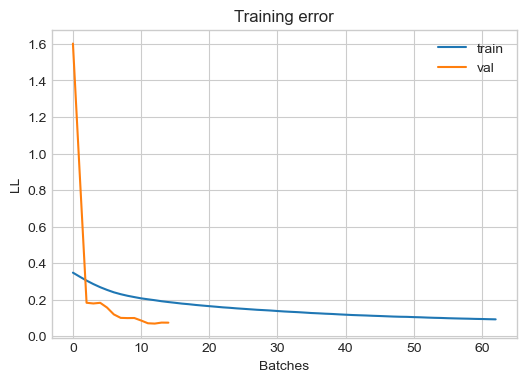

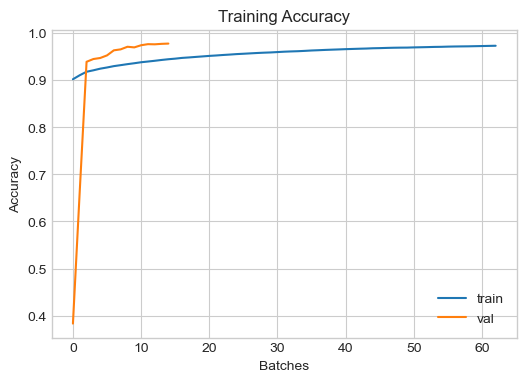

In [6]:
import numpy as np


def moving_average(x, window_size):
    """Calculate the moving average of a list using numpy."""
    return np.convolve(x, np.ones(window_size) / window_size, mode="valid")


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model.train_log_error, 100), label="train")
ax.plot(moving_average(model.val_log_error, 3), label="val")
ax.set_title(f"Training error")
ax.set_xlabel("Batches")
ax.set_ylabel("LL")
ax.legend()
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model.train_log_acc, 100), label="train")
ax.plot(moving_average(model.val_log_acc, 3), label="val")
ax.set_title(f"Training Accuracy")
ax.set_xlabel("Batches")
ax.set_ylabel("Accuracy")
ax.legend()
fig.show()

The model predicts the probability of each digit.

In [7]:
import torch.nn.functional as F


def plot_multiple_digits(model, batch_data, batch_labels, n_images: int = 10):
    "plot a grid of 5 images with their predictions"
    fig, ax = plt.subplots(figsize=(14, 4), ncols=n_images)
    for i in range(n_images):
        output_probs = F.softmax(model(batch_data[[i], :]), dim=1)[0]
        ax[i].imshow(batch_data[i].squeeze().numpy(), cmap="gray")
        ax[i].set_title(
            f"Pred: {torch.argsort(output_probs)[-1]}\nPred%: {output_probs[torch.argsort(output_probs)[-1]]:0.2f}\nLabel: {batch_labels[i]}\nLabel%: {output_probs[batch_labels[i]]:0.2f}"
        )
        ax[i].axis("off")

The model is very certain this is a 7. The model probabilities are given as:

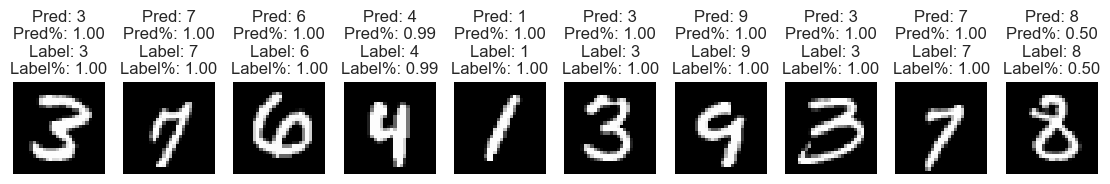

In [8]:
output_probs = plot_multiple_digits(model, batch_data, batch_labels)

In [9]:
import torch.nn.functional as F

output_probs = F.softmax(model(batch_data[[0], :]), dim=1)[0]
print([f"{val:0.2f}" for val in output_probs])


['0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


If we feed a perturbed digit, we still have high confidence.
The model doesn't have any way to suggest the digit is out of the training distribution.

We create a perturbed digit by rotating through 90 degrees.

In [10]:
class RotatedMNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64, rotation_angle=90.0):
        super().__init__()
        self.batch_size = batch_size
        self.rotation_angle = rotation_angle

    def setup(self, stage=None):
        transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                torchvision.transforms.RandomRotation(self.rotation_angle)
            ]
        )

        mnist_train = torchvision.datasets.MNIST(
            root="./data", train=True, download=True, transform=transform
        )
        mnist_test = torchvision.datasets.MNIST(
            root="./data", train=False, download=True, transform=transform
        )

        if stage == "fit" or stage is None:
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage == "test" or stage is None:
            self.mnist_test = mnist_test

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [11]:
rotated_data_module = RotatedMNISTDataModule(batch_size=2**10)
rotated_data_module.setup()
batch_rotated_data, batch_rotated_labels = next(iter(rotated_data_module.train_dataloader()))

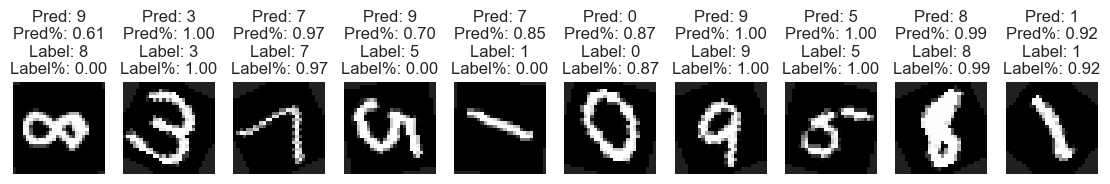

In [12]:
plot_multiple_digits(model, batch_rotated_data, batch_rotated_labels)

## Dirichlet model

We use the same network, but use the outputs as parameters for a Dirichlet distribution to act as a prior for the output multinomial distribution.


Paper reference: https://arxiv.org/pdf/1806.01768.pdf

Original logits output for a multinomial

In [39]:
x = model.features(batch_rotated_data)
print(x.shape)
x = x.view(batch_rotated_data.size(0), -1)
print(x.shape)
logits = model.classifier(x)
print(logits.shape)

F.softmax(logits, dim=1)[:2]

torch.Size([1024, 64, 7, 7])
torch.Size([1024, 3136])
torch.Size([1024, 10])


tensor([[1.0740e-04, 4.6795e-06, 1.4407e-03, 1.0600e-02, 8.6712e-02, 1.2271e-03,
         2.7817e-04, 2.9068e-01, 2.2229e-03, 6.0672e-01],
        [5.3206e-08, 3.4645e-10, 2.6333e-04, 9.9962e-01, 1.6306e-08, 1.9286e-05,
         5.3828e-11, 3.9853e-09, 4.4153e-05, 5.7737e-05]],
       grad_fn=<SliceBackward0>)

Dirichlet distribution

In [96]:
batch_rotated_labels

tensor([8, 3, 7,  ..., 0, 9, 8])

In [106]:
K = 10  # self.n_classes

# formulation 1
evidence = nn.ReLU()(logits)
S = torch.sum(evidence + 1, dim=1)
b_k = torch.divide(evidence, S.view(-1, 1))
u = K / S

# formulation 2
evidence = nn.ReLU()(logits)
alpha = evidence + 1    # concentration parameters of the dirichlet distribution
S = torch.sum(alpha, dim=1)
b_k = torch.divide(alpha - 1, S.view(-1, 1))
u = K / S

torch.sum(b_k, dim=1) + u # all sum correctly to 1

alpha/S.view(-1, 1) # class probabilities

# loss function - pdf -> likelihood, given the correct class = 1, all others = 0
# 1/B(alpha) Prod_i x_i^(alpha_i-1)

# sum over k outcome_k * (log(S) - log(alpha_k))
(torch.log(S).view(-1, 1) - torch.log(alpha))
alpha[batch_rotated_labels].shape

# select alpha values from only the positive class, all others are multiplied by 0 so dont calculate
alpha_positive = alpha[torch.arange(alpha.size(0)), batch_rotated_labels]
(torch.log(S) - torch.log(alpha_positive)).sum()


tensor(1705.9429, grad_fn=<SumBackward0>)

In [107]:
import torch.nn as nn


class DirichletModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, n_classes:int=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

        self.train_log_error = []
        self.train_log_acc = []
        self.val_log_error = []
        self.val_log_acc = []
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # flatten 2D channels to single vector for the linear layers
        logits = self.classifier(x)

        # logits to evidence (relu, must be positive)
        evidence = nn.ReLU()(logits)
        alpha = evidence + 1    # concentration parameters of the dirichlet distribution
        return alpha
    
        # S = torch.sum(alpha, dim=1)
        
        # b_k = torch.divide(alpha - 1, S.view(-1, 1))
        # K = self.n_classes
        # u = K / S

        return alpha/S.view(-1, 1) # class probabilities

    def loss_function(self, labels, alpha):
        # labels are the index of the positive class per row
        # select alpha values from only the positive class, all others are multiplied by 0 so dont calculate
        alpha_positive = alpha[torch.arange(alpha.size(0)), labels]
        S = torch.sum(alpha, dim=1)
        return (torch.log(S) - torch.log(alpha_positive)).sum()

    def concentration_to_probs(self, alpha):
        S = torch.sum(alpha, dim=1)
        return alpha/S.view(-1, 1) # class probabilities

    def training_step(self, batch, batch_idx):
        data, labels = batch
        alpha = self(data)

        loss = self.loss_function(labels, alpha)

        # Track training loss
        self.train_log_error.append(loss.item())
        
        # Calculate training accuracy
        probs = self.concentration_to_probs(alpha)
        _, predicted = torch.max(probs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        # Track training accuracy
        self.train_log_acc.append(accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        data, labels = batch
        alpha = self(data)

        loss = self.loss_function(labels, alpha)

        # Track training loss
        self.val_log_error.append(loss.item())
        # loss.detach().numpy()

        # Calculate training accuracy
        probs = self.concentration_to_probs(alpha)
        _, predicted = torch.max(probs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        # Track training accuracy
        self.val_log_acc.append(accuracy)

        return loss
    
    def configure_optimizers(self, learning_rate=1e-3):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=learning_rate,
        )
        return optimizer


Train model

In [108]:
model_d = DirichletModel()

trainer = pl.Trainer(max_epochs=3, gpus=1, accelerator="mps")
trainer.fit(model_d, data_module)

/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | features   | Sequential | 18.8 K
1 | classifier | Sequential | 402 K 
------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Plotting training performance shows we have converged nicely.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_73909/1358147501.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_73909/1358147501.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


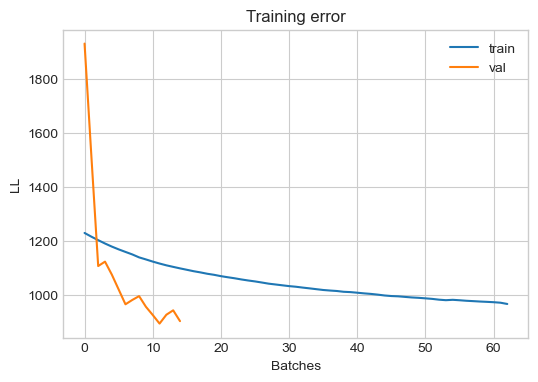

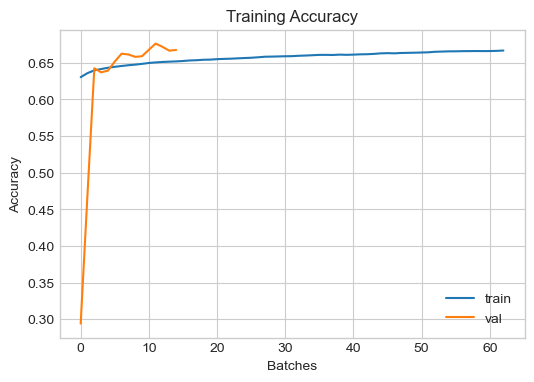

In [109]:
import numpy as np


def moving_average(x, window_size):
    """Calculate the moving average of a list using numpy."""
    return np.convolve(x, np.ones(window_size) / window_size, mode="valid")


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model_d.train_log_error, 100), label="train")
ax.plot(moving_average(model_d.val_log_error, 3), label="val")
ax.set_title(f"Training error")
ax.set_xlabel("Batches")
ax.set_ylabel("LL")
ax.legend()
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model_d.train_log_acc, 100), label="train")
ax.plot(moving_average(model_d.val_log_acc, 3), label="val")
ax.set_title(f"Training Accuracy")
ax.set_xlabel("Batches")
ax.set_ylabel("Accuracy")
ax.legend()
fig.show()

The model is very certain this is a 7. The model probabilities are given as:

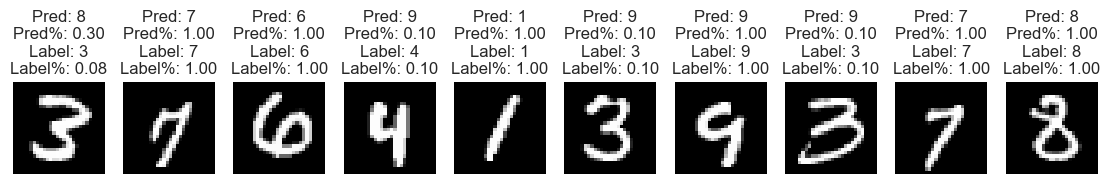

In [111]:
output_probs = plot_multiple_digits(model_d, batch_data, batch_labels)

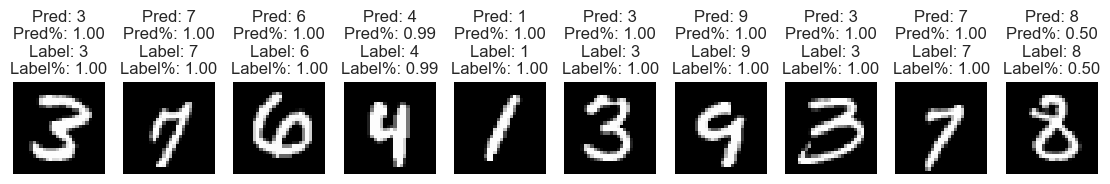

In [112]:
output_probs = plot_multiple_digits(model, batch_data, batch_labels)

# TODO

* KL divergence
* Simulate with two classes - is it equivalent to beta distribtuions
* simulate with three classes and plot distributions

In [18]:
import pytorch_lightning as pl
import torch
import torch.distributions
from typing import List


class BetaModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, prior_parameters: List[float] = None):
        super().__init__()

        if prior_parameters is None:
            prior_parameters = [0.5, 0.5]
        else:
            assert len(prior_parameters) == 2
            assert prior_parameters[0] > 0
            assert prior_parameters[1] > 0

        prior_parameters_invsp = inv_softplus(torch.tensor(prior_parameters))
        self.beta_params_invsp = torch.nn.Parameter(prior_parameters_invsp)

        self.train_log_error = []
        self.val_log_error = []
        self.beta_params_log = []
        self.learning_rate = learning_rate

    def forward(self):
        beta_params_pos = torch.nn.functional.softplus(self.beta_params_invsp)
        dist = torch.distributions.beta.Beta(beta_params_pos[0], beta_params_pos[1])
        return dist

    def training_step(self, batch, batch_idx):
        y = batch[0]

        # find loglikelihood of y given our current distribution estimate
        dist = self.forward()
        negloglik = -dist.log_prob(y.mean())
        loss = torch.mean(negloglik)

        # log training results
        self.train_log_error.append(loss.detach().numpy())
        self.beta_params_log.append(
            torch.nn.functional.softplus(self.beta_params_invsp).detach().numpy()
        )
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        # find loglikelihood of y given our current distribution estimate
        dist = self.forward()
        negloglik = -dist.log_prob(y)
        loss = torch.mean(negloglik)

        # log training results
        self.val_log_error.append(loss.detach().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

# Non-contextual version
We can fit a Beta distribution to random binary data with pytorch.


## Generate data

We need data for a classification problem.

We will first make a non-contextual version.
We generate data from Bernouli trials with a known success probability.


In [19]:
# true distribution parameters
p_success = 0.7
n_samples = 10000

rand_gen = np.random.default_rng(seed=0)

rand_samples = rand_gen.binomial(n=1, p=p_success, size=(n_samples, 1))

display(rand_samples[:10].flatten())
print(f"Average: {rand_samples.mean()}")

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

Average: 0.6999


## Fit pytorch model

The uninformed prior distribution for a Beta is commonly parameterised as [0.5, 0.5].
Within a pytorch model we need to ensure the parameters remain in the correct domain.
Beta parameters must be positive, therefore we use the soft plus function to convert them.


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_18424/90226784.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


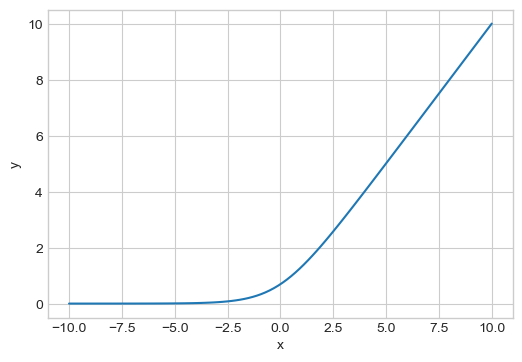

In [20]:
import torch
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
x = torch.linspace(-10, 10, 100)
y = torch.nn.functional.softplus(x)
ax.plot(x, y)
ax.set(xlabel="x", ylabel="y", title="")
fig.show()

To get the equivalent uninformed prior distribution parameters we can find the inverse soft plus, [ref](https://github.com/pytorch/pytorch/issues/72759).

In [21]:
def inv_softplus(x):
    return x + torch.log(-torch.expm1(-x))


torch.nn.functional.softplus(inv_softplus(torch.tensor(0.5)))
inv_softplus(torch.tensor(0.5))

tensor(-0.4328)

We can now construct our Beta distribution in pytorch.

In [22]:
import pytorch_lightning as pl
import torch
import torch.distributions
from typing import List


class BetaModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, prior_parameters: List[float] = None):
        super().__init__()

        if prior_parameters is None:
            prior_parameters = [0.5, 0.5]
        else:
            assert len(prior_parameters) == 2
            assert prior_parameters[0] > 0
            assert prior_parameters[1] > 0

        prior_parameters_invsp = inv_softplus(torch.tensor(prior_parameters))
        self.beta_params_invsp = torch.nn.Parameter(prior_parameters_invsp)

        self.train_log_error = []
        self.val_log_error = []
        self.beta_params_log = []
        self.learning_rate = learning_rate

    def forward(self):
        beta_params_pos = torch.nn.functional.softplus(self.beta_params_invsp)
        dist = torch.distributions.beta.Beta(beta_params_pos[0], beta_params_pos[1])
        return dist

    def training_step(self, batch, batch_idx):
        y = batch[0]

        # find loglikelihood of y given our current distribution estimate
        dist = self.forward()
        negloglik = -dist.log_prob(y.mean())
        loss = torch.mean(negloglik)

        # log training results
        self.train_log_error.append(loss.detach().numpy())
        self.beta_params_log.append(
            torch.nn.functional.softplus(self.beta_params_invsp).detach().numpy()
        )
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        # find loglikelihood of y given our current distribution estimate
        dist = self.forward()
        negloglik = -dist.log_prob(y)
        loss = torch.mean(negloglik)

        # log training results
        self.val_log_error.append(loss.detach().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

Lets create the model:

In [23]:
torch.manual_seed(1)
model = BetaModel(learning_rate=1e1)

Now we can generate distribution objects from the model by calling the forward pass method.
We see the model does not yet know anything about the true success probability.

In [24]:
x = np.linspace(0, 1, 1000)
output_dist = model()
y = scipy.stats.beta(output_dist.concentration0.detach().numpy(), output_dist.concentration1.detach().numpy()).pdf(x)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, label="Prior distribution")
ax.axvline(x=p_success, linestyle="--", color="b", alpha=0.5, label="True P(success)")
ax.legend()
ax.set(xlabel="P(success)", ylabel="PDF", title="Prior distribution")
fig.show()

NameError: name 'scipy' is not defined

## Fitting the model distribution
To train the model with our random sample data created above, we need to setup a dataloader to pass to the trainer.

In [ ]:
# training on the whole dataset each batch
from torch.utils.data import TensorDataset, DataLoader

rand_samples_t = torch.Tensor(rand_samples)
dataset_train = TensorDataset(rand_samples_t)
dataloader_train = DataLoader(dataset_train, batch_size=len(rand_samples))

# test loading a batch
rand_samples_batch = next(iter(dataloader_train))
rand_samples_batch[0].shape

torch.Size([10000, 1])

Now we can train the model via PyTorch Lightning's Trainer object.

In [ ]:
# fit network
trainer = pl.Trainer(max_epochs=50, accelerator="cpu")
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/train

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s, v_num=30]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s, v_num=30]


We can see the training loss has converged ok.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/2207435402.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


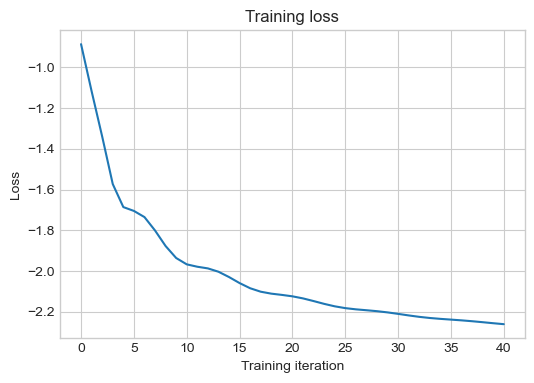

In [ ]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(np.array(model.train_log_error)))
ax.set(ylabel="Loss",xlabel="Training iteration", title='Training loss')
fig.show()

The beta parameters are moving towards appropriate values.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/4205145043.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


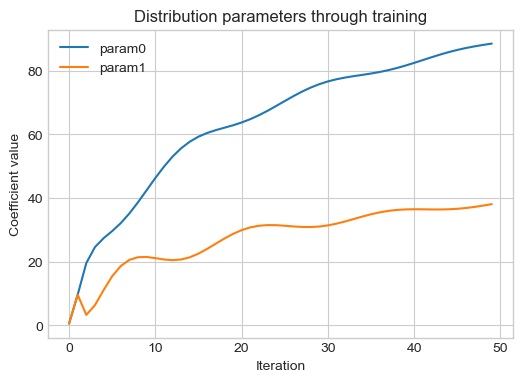

In [ ]:
beta_params_log = np.array(model.beta_params_log)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(beta_params_log[:, 0], label="param0")
ax.plot(beta_params_log[:, 1], label="param1")
ax.legend()
ax.set(xlabel="Iteration", ylabel="Coefficient value", title='Distribution parameters through training')
fig.show()

Plotting distribution against interation

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/1794095813.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


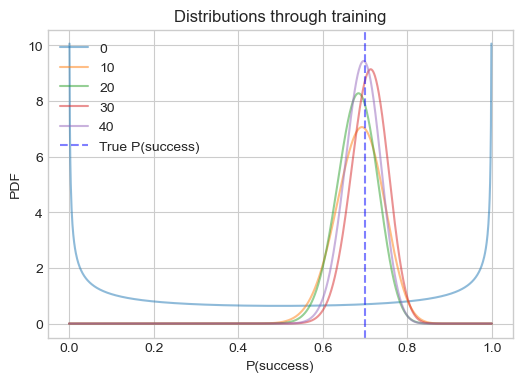

In [ ]:
beta_params_log = np.array(model.beta_params_log)
x = np.linspace(0, 1, 1000)
iterations = range(0, beta_params_log.shape[0], 10)

fig, ax = plt.subplots(figsize=(6, 4))
for idx in iterations:
    y = scipy.stats.beta(*beta_params_log[idx, :]).pdf(x)
    ax.plot(x, y, alpha=0.5, label=idx)

ax.axvline(x=p_success, linestyle="--", color="b", alpha=0.5, label="True P(success)")
ax.legend()
ax.set(xlabel="P(success)", ylabel="PDF", title="Distributions through training")
fig.show()

### Comparison with maximum likelihood estimation


The true beta parameters for this data can be calculated as the sum of the successes and the sum of the failures.

In [ ]:
print("MLE parameters")
print((rand_samples == 1).sum())
print((rand_samples == 0).sum())

MLE parameters
6999
3001


The MLE distribution is a very tight fit around the true success probability.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/2078173807.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


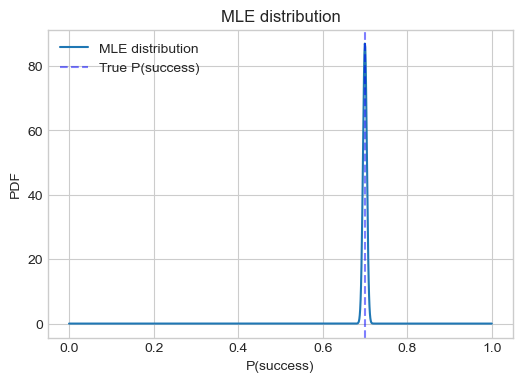

In [ ]:
x = np.linspace(0, 1, 1000)
y = scipy.stats.beta((rand_samples == 1).sum(), (rand_samples == 0).sum()).pdf(x)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, label="MLE distribution")
ax.axvline(x=p_success, linestyle="--", color="b", alpha=0.5, label="True P(success)")
ax.set(xlabel="P(success)", ylabel="PDF", title="MLE distribution")
ax.legend()
fig.show()

This is shown also in the log likelihood of observing the data given the distribution.
The MLE LL is expectedly better (higher):

In [ ]:
print(
    f"MLE LL: {scipy.stats.beta((rand_samples==1).sum(), (rand_samples==0).sum()).logpdf(rand_samples.mean()):.2f}"
)
print(
    f"NN LL: {scipy.stats.beta(*beta_params_log[-1,:]).logpdf(rand_samples.mean()):.2f}"
)

MLE LL: 4.47
NN LL: 2.28


However, when we want to make the distribution a function of various features we cannot use the MLE approach in the same way.
Gradient descent however can still be used.

## Using the reparameterisation trick

The above beta based models fits the parameters to the average success probability, not to the individual sample.
When building a contextual model we need to use the individual output labels as the average success prob is non-contextual.
When we take the PDF of a beta distribution for the individual sample we get a prob of 0, as the individual output labels are 0 or 1.
Therefore we need another way. One such way is to use separate predicted distribution parameters for each data point.
We can sample from that distribution for each data point.
Sampling, however, breaks the derivative chain needed for back propagation to train the model weights.
Therefore we use the reparameterisation to formulate the samples as a function of the distribution parameters.
This allows training the model weights using the output labels from individual samples.

Specifically in the following we construct a beta distribution and call `rsample`.
The sample will be a draw from the beta representing the probability of success.
We can then use binary cross entropy loss as usual on the true output labels to evaluate.


In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.distributions
from typing import List


class BetaModelSample(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, prior_parameters: List[float] = None):
        super().__init__()

        if prior_parameters is None:
            prior_parameters = [0.5, 0.5]
        else:
            assert len(prior_parameters) == 2
            assert prior_parameters[0] > 0
            assert prior_parameters[1] > 0

        prior_parameters_invsp = inv_softplus(torch.tensor(prior_parameters))
        self.beta_params_invsp = torch.nn.Parameter(prior_parameters_invsp)

        self.train_log_error = []
        self.val_log_error = []
        self.beta_params_log = []
        self.learning_rate = learning_rate

    def forward(self):
        beta_params_pos = torch.nn.functional.softplus(self.beta_params_invsp)
        dist = torch.distributions.beta.Beta(beta_params_pos[0], beta_params_pos[1])
        return dist

    def training_step(self, batch, batch_idx):
        y = batch[0]

        # find a sample of our current distribution estimate
        dist = self.forward()
        dist_sample = dist.rsample(y.shape)

        criterion = nn.BCELoss()
        loss = criterion(dist_sample, y).mean()

        # log training results
        self.train_log_error.append(loss.detach().numpy())
        self.beta_params_log.append(
            torch.nn.functional.softplus(self.beta_params_invsp).detach().numpy()
        )
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        # find a sample of our current distribution estimate
        dist = self.forward()
        dist_sample = dist.rsample(y.shape)
        
        criterion = nn.BCELoss()
        loss = criterion(dist_sample, y).mean()

        # log training results
        self.val_log_error.append(loss.detach().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer


Lets create the model:

In [ ]:
torch.manual_seed(1)
model = BetaModelSample(learning_rate=1e0)

## Fitting the model distribution
To train the model with our random sample data created above, we need to setup a dataloader to pass to the trainer.

Now we can train the model via PyTorch Lightning's Trainer object.

In [ ]:
# fit network
trainer = pl.Trainer(max_epochs=100, accelerator="cpu")
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 2     
--------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=31]        

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s, v_num=31]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s, v_num=31]


The beta parameters are moving towards appropriate values.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/4205145043.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


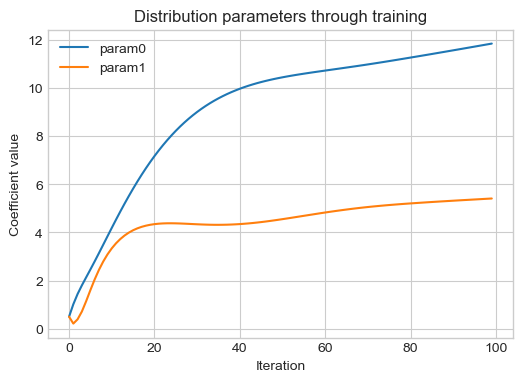

In [ ]:
beta_params_log = np.array(model.beta_params_log)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(beta_params_log[:, 0], label="param0")
ax.plot(beta_params_log[:, 1], label="param1")
ax.legend()
ax.set(xlabel="Iteration", ylabel="Coefficient value", title='Distribution parameters through training')
fig.show()

Plotting distribution against interation

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/1794095813.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


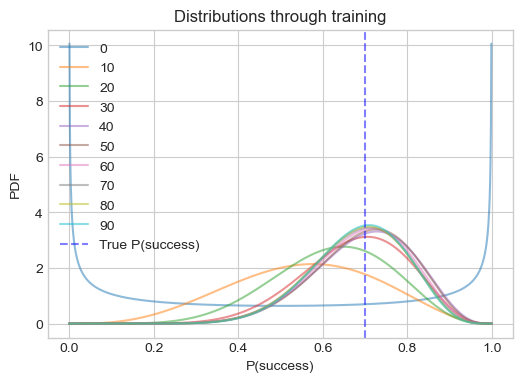

In [ ]:
beta_params_log = np.array(model.beta_params_log)
x = np.linspace(0, 1, 1000)
iterations = range(0, beta_params_log.shape[0], 10)

fig, ax = plt.subplots(figsize=(6, 4))
for idx in iterations:
    y = scipy.stats.beta(*beta_params_log[idx, :]).pdf(x)
    ax.plot(x, y, alpha=0.5, label=idx)

ax.axvline(x=p_success, linestyle="--", color="b", alpha=0.5, label="True P(success)")
ax.legend()
ax.set(xlabel="P(success)", ylabel="PDF", title="Distributions through training")
fig.show()

The model is converging correctly, but slower than before.

A question for another day - does this actually accurately represent the uncertainty here?

# Appendix

TODO:

* Quantile regression from a multi head NN
  * Using pinball loss
* Variational inference approach
* Dropout approach
* Bootstrapped NNs/ensemble networks
  * Fit a different model on bootstrap samples, predict from all
* MCMC
* Empirical bayes




## How to create a bayesian model

* **Bayesian Logistic regression?**
  * Distribution over parameter weights in final layer only
  * Similar to contextual bandits
* Variational inference on logistic regression layer weights
* Parameterised beta distribution
  * Logistic regression and beta distributions share no direct link [ref](https://stats.stackexchange.com/questions/259131/what-is-the-relationship-between-the-beta-distribution-and-the-logistic-regressi)
  * How do we fit the loglikelihood of the beta? Common for the PDF to be 0 (logloss of -inf) at 0 and 1.
  * Truncate outcomes to 0.01 and 0.99 for a hack?
  * Conceptually it makes sense?
    * data generating only 1s. beta concentrating at 1 will give higher prob of success than one less certain
    * find log loss of mean outcome? should work. we find the average success and find the log loss of that given our beta
* Dirichlet distribution
  * **Empirical bayes to find prior parameters from data**
    * ref - https://arxiv.org/pdf/1806.01768.pdf
    * code - https://muratsensoy.github.io/uncertainty.html
  * Same solution as parameterised beta
    * How to simplify for singke beta?
    * 
* Having a spare label for 'uncertain'
  * how to train in a binary classification sense?
* Dropout based approaches
* bandits
  * To enable bandits we need to sample from some posterior distribution
  * here would be a beta distribution or sampling from logistic regression weights
* Ensembles
  * Train multiple networks on the same dataset with random initialisation. Predict from all.

## Drop out

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.distributions
from typing import List


class DropOutModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, prior_parameters: List[float] = None):
        super().__init__()

        if prior_parameters is None:
            prior_parameters = [0.5, 0.5]
        else:
            assert len(prior_parameters) == 2
            assert prior_parameters[0] > 0
            assert prior_parameters[1] > 0

        prior_parameters_invsp = inv_softplus(torch.tensor(prior_parameters))
        self.beta_params_invsp = torch.nn.Parameter(prior_parameters_invsp)

        self.train_log_error = []
        self.val_log_error = []
        self.beta_params_log = []
        self.learning_rate = learning_rate

    def forward(self):
        beta_params_pos = torch.nn.functional.softplus(self.beta_params_invsp)
        dist = torch.distributions.beta.Beta(beta_params_pos[0], beta_params_pos[1])
        return dist

    def training_step(self, batch, batch_idx):
        y = batch[0]

        # find a sample of our current distribution estimate
        dist = self.forward()
        dist_sample = dist.rsample(y.shape)

        criterion = nn.BCELoss()
        loss = criterion(dist_sample, y).mean()

        # log training results
        self.train_log_error.append(loss.detach().numpy())
        self.beta_params_log.append(
            torch.nn.functional.softplus(self.beta_params_invsp).detach().numpy()
        )
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        # find a sample of our current distribution estimate
        dist = self.forward()
        dist_sample = dist.rsample(y.shape)
        
        criterion = nn.BCELoss()
        loss = criterion(dist_sample, y).mean()

        # log training results
        self.val_log_error.append(loss.detach().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer


Lets create the model:

In [ ]:
torch.manual_seed(1)
model = BetaModelSample(learning_rate=1e0)

## Fitting the model distribution
To train the model with our random sample data created above, we need to setup a dataloader to pass to the trainer.

Now we can train the model via PyTorch Lightning's Trainer object.

In [ ]:
# fit network
trainer = pl.Trainer(max_epochs=100, accelerator="cpu")
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 2     
--------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=31]        

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.51it/s, v_num=31]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s, v_num=31]


The beta parameters are moving towards appropriate values.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/4205145043.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


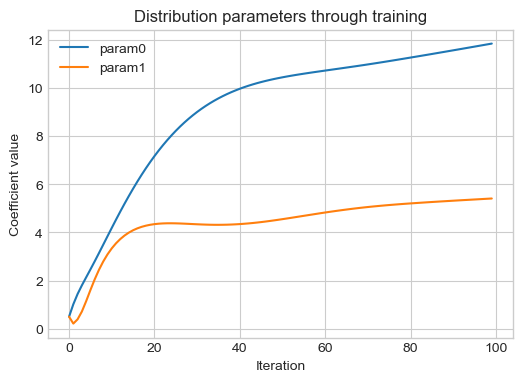

In [ ]:
beta_params_log = np.array(model.beta_params_log)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(beta_params_log[:, 0], label="param0")
ax.plot(beta_params_log[:, 1], label="param1")
ax.legend()
ax.set(xlabel="Iteration", ylabel="Coefficient value", title='Distribution parameters through training')
fig.show()

Plotting distribution against interation

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_46321/1794095813.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


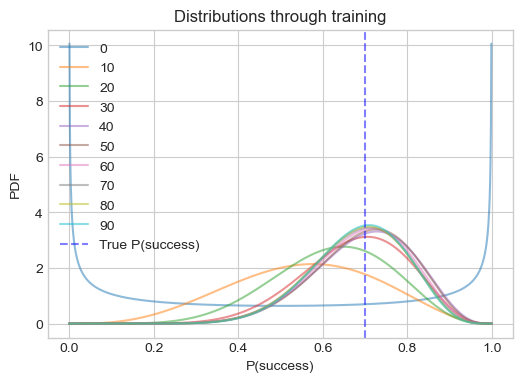

In [ ]:
beta_params_log = np.array(model.beta_params_log)
x = np.linspace(0, 1, 1000)
iterations = range(0, beta_params_log.shape[0], 10)

fig, ax = plt.subplots(figsize=(6, 4))
for idx in iterations:
    y = scipy.stats.beta(*beta_params_log[idx, :]).pdf(x)
    ax.plot(x, y, alpha=0.5, label=idx)

ax.axvline(x=p_success, linestyle="--", color="b", alpha=0.5, label="True P(success)")
ax.legend()
ax.set(xlabel="P(success)", ylabel="PDF", title="Distributions through training")
fig.show()

## Exploring distributions

In [ ]:
import torch
import torch.distributions

dist = torch.distributions.beta.Beta(torch.tensor([0.5]), torch.tensor([0.5]))
print(dist.sample(sample_shape=torch.Size([100])))

dist = torch.distributions.dirichlet.Dirichlet(torch.tensor([0.5, 0.5, 0.5]))
print(dist.sample())

dist = torch.distributions.dirichlet.Dirichlet(torch.tensor([15.0, 15.0, 15.0]))
print(dist.sample())

tensor([[8.3494e-01],
        [3.7288e-01],
        [3.5481e-02],
        [8.3579e-01],
        [9.3016e-01],
        [8.3434e-01],
        [5.0013e-01],
        [3.0261e-02],
        [3.7120e-01],
        [8.7680e-01],
        [9.4178e-01],
        [9.7501e-01],
        [7.6039e-01],
        [6.3000e-01],
        [9.9853e-01],
        [2.3499e-02],
        [4.0206e-01],
        [2.3386e-01],
        [3.2975e-01],
        [5.1398e-01],
        [6.0042e-01],
        [3.1419e-01],
        [3.6251e-02],
        [8.5917e-01],
        [6.5136e-02],
        [7.3362e-01],
        [6.4062e-02],
        [8.2373e-02],
        [1.3393e-01],
        [8.1192e-02],
        [9.1860e-01],
        [9.2060e-01],
        [2.3496e-03],
        [4.3059e-01],
        [8.8154e-01],
        [3.8501e-01],
        [7.8591e-02],
        [2.3580e-01],
        [6.5333e-01],
        [1.9788e-04],
        [5.0260e-01],
        [3.3609e-01],
        [9.9853e-01],
        [7.6449e-01],
        [1.2517e-01],
        [9

## Generate random data

I'll make random data from two beta distributions and then select from them randomly to get two peaks.
I'll deliberately make the distributions fairly distinct to make the initial analysis easier to visualise.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

# true distribution parameters
p_d1 = 0.5
p_lambda = 5

n = 10000
rand_gen = np.random.default_rng(seed=0)

poisson_samples = rand_gen.poisson(lam=p_lambda, size=(n, 1))
mix_samples = rand_gen.binomial(n=1, p=p_d1, size=(n, 1))
rand_samples = mix_samples * poisson_samples

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rand_samples, bins=50)
plt.show()

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## Creating a PyTorch model

Assuming we know the underlying generating model (...strong assumption...?), we can construct a network that builds the equivalent distribution objects in PyTorch.

We are fitting the distribution parameters.
As such we have no input features for the forward pass, only the output values.
We use negative log likelihood as the loss function to optimise.

In [ ]:
import pytorch_lightning as pl
import torch


class ZIPModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=1e-3,
        init_mix_parameter: float = 0.5,
        init_poisson_lambda: float = 1.0,
    ):
        super().__init__()
        self.mixture_prob = torch.nn.Parameter(torch.tensor([init_mix_parameter]))
        self.poisson_lambda = torch.nn.Parameter(torch.tensor([init_poisson_lambda]))

        self.train_log_error = []
        self.val_log_error = []
        self.mixture_prob_log = []
        self.poisson_lambda_log = []
        self.learning_rate = learning_rate

    def forward(self):
        # ensure correct domain for params
        mixture_prob_norm = torch.sigmoid(self.mixture_prob)
        poisson_lambda_norm = torch.nn.functional.softplus(self.poisson_lambda)
        poisson_lambda_norm = torch.concat(
            (torch.tensor([0.0]), poisson_lambda_norm)
        )  # maintains grad

        mix = torch.distributions.Categorical(
            torch.concat((mixture_prob_norm, 1 - mixture_prob_norm))
        )
        poissons = torch.distributions.Poisson(poisson_lambda_norm)

        mixture_dist = torch.distributions.MixtureSameFamily(mix, poissons)
        return mixture_dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        self.poisson_lambda_log.append(
            torch.nn.functional.softplus(self.poisson_lambda).detach().numpy()
        )
        self.mixture_prob_log.append(torch.sigmoid(self.mixture_prob).detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        return loss

Lets create the model:

In [ ]:
# create model
torch.manual_seed(1)
model = ZIPModel(learning_rate=1e-0, init_mix_parameter=0.5, init_poisson_lambda=4.5)

Now we can generate distribution objects from the model by calling the forward pass method.

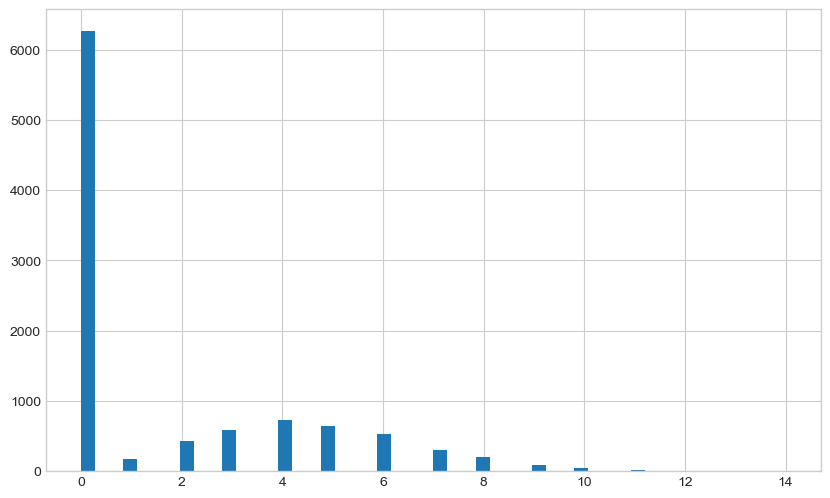

In [ ]:
# get some samples
output_dist = model()
output_samples = output_dist.sample((n, 1)).numpy().squeeze()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(output_samples, bins=50)
plt.show()

## Fitting the model distribution
To train the model with our random sample data created above, we need to setup a dataloader to pass to the trainer.

In [ ]:
# training on the whole dataset each batch
from torch.utils.data import TensorDataset, DataLoader

rand_samples_t = torch.Tensor(rand_samples)
dataset_train = TensorDataset(rand_samples_t)
dataloader_train = DataLoader(dataset_train, batch_size=len(rand_samples))

# test loading a batch
rand_samples_batch = next(iter(dataloader_train))
rand_samples_batch[0].shape

torch.Size([10000, 1])

Now we can train the model via PyTorch Lightning's Trainer object.

In [ ]:
# fit network
trainer = pl.Trainer(
    max_epochs=100,
)
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connecto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


We can see the training loss has converged ok.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_82119/2590399248.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


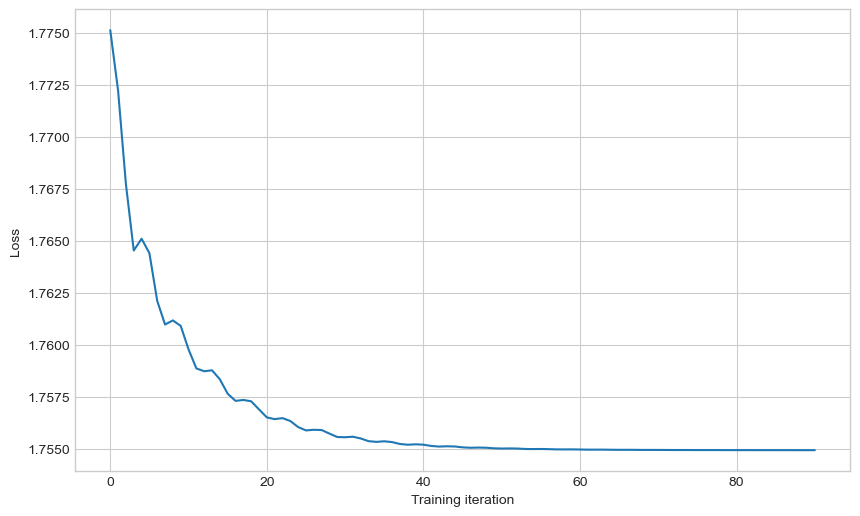

In [ ]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(moving_average(np.array(model.train_log_error)))
ax.set_ylabel("Loss")
ax.set_xlabel("Training iteration")
fig.show()

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_82119/2571154232.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


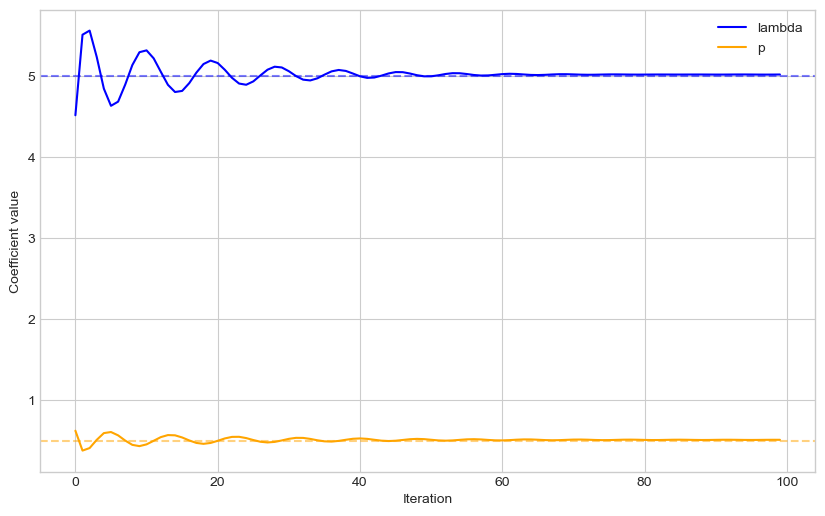

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model.poisson_lambda_log, color="b", label="lambda")
ax.plot(model.mixture_prob_log, color="orange", label="p")
ax.axhline(y=p_lambda, linestyle="--", color="b", alpha=0.5)
ax.axhline(y=p_d1, linestyle="--", color="orange", alpha=0.5)
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")
fig.show()

## Checking results
Now we can check the resulting distribution that comes out of our model and compare that directly to the random samples.

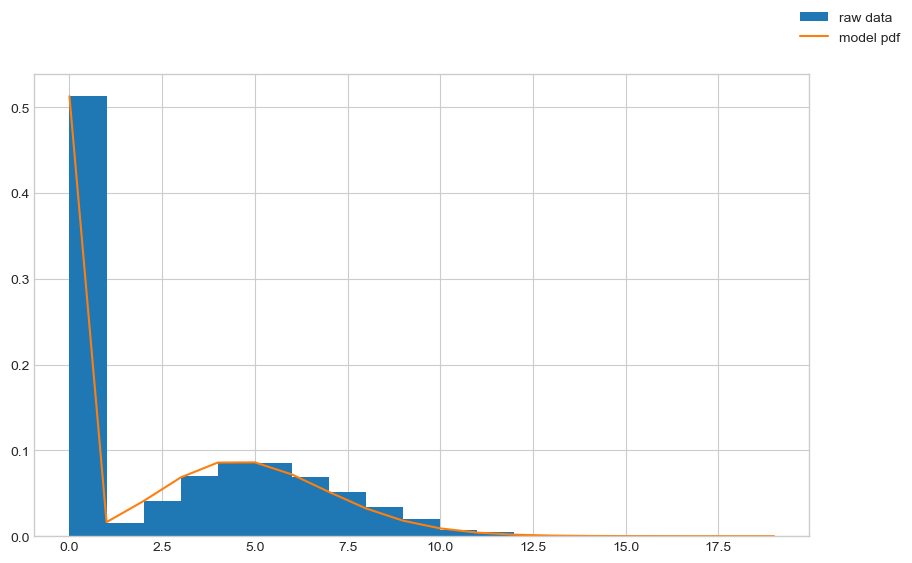

In [ ]:
# plot pdf
output_dist = model()
x = torch.arange(0, 20)
y = torch.exp(output_dist.log_prob(x))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    rand_samples,
    bins=rand_samples.max() - rand_samples.min(),
    density=True,
    label="raw data",
)
ax.plot(x.detach().numpy(), y.detach().numpy(), label="model pdf")
fig.legend()
plt.show()

We can see that the trained distribution parameters now are close to the underlying parameters.

In [ ]:
print("Final mix:", model.mixture_prob_log[-1][0])
print("Final lambda:", model.poisson_lambda_log[-1][0])

print("True mix:", p_d1)
print("True lambda:", p_lambda)

Final mix: 0.5104645
Final lambda: 5.013678
True mix: 0.5
True lambda: 5


### Random seeding
We can start the training from different random initialisations to see how smooth the objective function surface is.

In [ ]:
import random

seed_model_params = []
for _idx in range(10):
    print(_idx)
    init_params = [random.random(), random.random() * 10]
    model = ZIPModel(
        learning_rate=1e-0,
        init_mix_parameter=init_params[0],
        init_poisson_lambda=init_params[1],
    )

    # fit network
    trainer = pl.Trainer(
        max_epochs=100,
    )
    trainer.fit(model, dataloader_train)

    seed_model_params.append(
        {
            "err": model.train_log_error[-1],
            "mixture": model.mixture_prob_log[-1],
            "lambda": model.poisson_lambda_log[-1],
            "mixture_init": init_params[0],
            "lambda_init": init_params[1],
        }
    )

0


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


1


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


2


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


3


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


4


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


5


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


6


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


7


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


8


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


9


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
import pandas as pd

pd.DataFrame(seed_model_params)

,err,mixture,lambda,mixture_init,lambda_init
0,1.7549713,[0.5084596],[4.990373],0.206126,1.271737
1,1.7549436,[0.5095606],[5.0154147],0.957375,5.609975
2,1.75495,[0.50945556],[5.0249567],0.113368,9.019589
3,1.7549486,[0.51113284],[5.019183],0.024360,2.504726
4,1.7549453,[0.50945634],[5.0075474],0.422956,6.300903
5,1.7549646,[0.5087664],[4.992894],0.317083,1.335294
6,1.7549437,[0.50981426],[5.016553],0.569097,3.339710
7,1.7549523,[0.51095116],[5.002224],0.146055,8.153884
8,1.7549479,[0.50936157],[5.022941],0.538195,3.024650
9,1.7549556,[0.50825804],[5.0001493],0.075363,9.901132


Compared with the true parameters, it looks like we're converging well in each case.

So seems successful overall! This approach makes it quite easy to train fairly complex distributions without having to understand the particular methods for fitting that distribution type (if they even exist).

## Creating a PyTorch distribution object

The solution is a bit hacky - we need to define the mixture of two of the same types, so we used a Poisson distribution with a $\lambda$ of 0.
Can we reformulate this is a pytorch distribution class instead?

The poisson class in PyTorch is based around the following (simplified) form:
```python
class Poisson(ExponentialFamily):
    def __init__(self, rate, validate_args=None):
        self.rate = rate
        super(Poisson, self).__init__(batch_shape, validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            return torch.poisson(self.rate.expand(shape))

    def log_prob(self, value):
        return value.xlogy(self.rate) - self.rate - (value + 1).lgamma()

    ...
```

Can we build the equivalent zero-inflated Poisson distribution?

We need to specify a `sample` and `log-prob` method. For both of those we need to find an expression for the product mass function (PMF).

### PMF
Poisson PMF:
$$\mathrm{P_{s}}(Y=k | \lambda) = \frac{\lambda^{k} e^{-\lambda }} {k!}$$

Bernoulli PMF:
$$
\begin{align*}
\mathrm{P_{d}}(Y=0) &= \pi\\
\mathrm{P_{d}}(Y!=0) &= 1-\pi
\end{align*}
$$

Mixture distribution:
$$\mathrm{P}(Y) = \mathrm{P_{d}}(Y) \mathrm{P_{s}}(Y)$$

This is the expression we implement to create the `sample` method.


We need to dig further to get the full expression.
The zero case:
$$
\begin{align*}
\mathrm{P}(Y=0) &= \mathrm{P_{d}}(Y=0) + \mathrm{P_{d}}(Y=1) \mathrm{P_{s}}(Y=0 | \lambda)\\
                &= \pi + (1-\pi) \frac{\lambda^{0} e^{-\lambda }} {0!}\\
                &= \pi + (1-\pi) e^{-\lambda }
\end{align*}
$$

The non-zero case:
$$\mathrm{P}(Y=k) = (1-\pi) \frac{\lambda^{k} e^{-\lambda }} {k!}$$

### Log probs
Log of the above:
$$\log{\mathrm{P}(Y=0)} = \log(\pi + (1-\pi) e^{-\lambda })$$

Non zero case:
$$
\begin{align*}
\log{\mathrm{P}(Y=k)} &= \log((1-\pi) \frac{\lambda^{k} e^{-\lambda }} {k!})\\
                      &= \log(1-\pi) + \log(\frac{\lambda^{k} e^{-\lambda }} {k!})\\
                      &= \log(1-\pi) + \log(\lambda^{k} e^{-\lambda }) -\log(k!)\\
                      &= \log(1-\pi) + k\log(\lambda) -\lambda -\log(\Gamma(k+1))
\end{align*}
$$


We can create those expression inside a new class:

In [ ]:
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import broadcast_all


class ZeroInflatedPoisson(ExponentialFamily):
    arg_constraints = {"p": constraints.unit_interval, "rate": constraints.nonnegative}
    support = constraints.nonnegative_integer

    def __init__(self, p, rate, validate_args=None):
        self.p, self.rate = broadcast_all(p, rate)
        if isinstance(rate, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.rate.size()
        super(ZeroInflatedPoisson, self).__init__(
            batch_shape, validate_args=validate_args
        )

    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            zero = torch.bernoulli(self.p.expand(shape))
            poisson = torch.poisson(self.rate.expand(shape))
            return zero * poisson

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        rate, p, value = broadcast_all(self.rate, self.p, value)
        poisson_log_prob = value.xlogy(rate) - rate - (value + 1).lgamma()
        poisson_log_prob[torch.where(value == 0.0)] = torch.log(
            p + (1 - p) * torch.exp(-rate)
        )[torch.where(value == 0.0)]
        poisson_log_prob[value > 0.0] = (
            torch.log(1 - p)[value > 0.0] + poisson_log_prob[value > 0.0]
        )
        return poisson_log_prob

We can sample from the distribution object and it looks good:

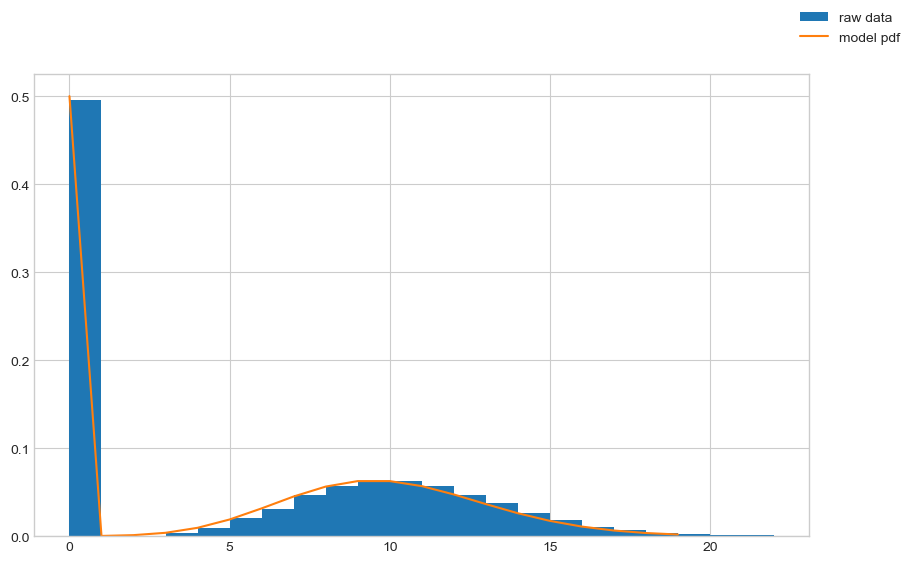

In [ ]:
dist = ZeroInflatedPoisson(p=0.5, rate=10.0)
samples = dist.sample(sample_shape=(10000,))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    samples, bins=int(samples.max() - samples.min()), density=True, label="raw data"
)

# plot pdf
x = torch.arange(0, 20)
y = torch.exp(dist.log_prob(x))

ax.plot(x.detach().numpy(), y.detach().numpy(), label="model pdf")
fig.legend()
plt.show()

Can we fit the same model with the output as a `ZeroInflatedPoisson`?

We can build the model class with the new distribution object as the output:

In [ ]:
class DistZIPModel(ZIPModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self):
        # ensure correct domain for params
        mixture_prob_norm = torch.sigmoid(self.mixture_prob)
        poisson_lambda_norm = torch.nn.functional.softplus(self.poisson_lambda)

        zip_dist = ZeroInflatedPoisson(p=mixture_prob_norm, rate=poisson_lambda_norm)
        return zip_dist

Similarly to before, we can then fit the model multiple times from random starting seeds.

In [ ]:
import random

seed_model_params = []
for _idx in range(10):
    print(_idx)
    init_params = [random.random(), random.random() * 10]
    model = DistZIPModel(
        learning_rate=1e-0,
        init_mix_parameter=init_params[0],
        init_poisson_lambda=init_params[1],
    )

    # fit network
    trainer = pl.Trainer(
        max_epochs=100,
    )
    trainer.fit(model, dataloader_train)

    seed_model_params.append(
        {
            "err": model.train_log_error[-1],
            "mixture": model.mixture_prob_log[-1][0],
            "lambda": model.poisson_lambda_log[-1][0],
            "mixture_init": init_params[0],
            "lambda_init": init_params[1],
        }
    )

0


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connecto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


1


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


2


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


3


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


4


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


5


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


6


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


7


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


8


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


9


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


We get similar results to last time, so the training is working:

In [ ]:
import pandas as pd

pd.DataFrame(seed_model_params)

,err,mixture,lambda,mixture_init,lambda_init
0,1.7549562,0.509187,4.996997,0.903635,2.128501
1,1.75495,0.510270,5.002354,0.465512,8.292895
2,1.7549443,0.509034,5.013655,0.527130,5.674198
3,1.7549495,0.510738,5.004287,0.960527,7.272479
4,1.7549485,0.510341,5.022951,0.543747,7.638310
5,1.7549614,0.509203,5.032393,0.378267,0.567890
6,1.7549452,0.509837,5.007850,0.241634,1.943764
7,1.754977,0.508137,5.037724,0.597536,0.653239
8,1.7549465,0.510558,5.019430,0.807217,6.436518
9,1.754944,0.509288,5.011004,0.871826,8.402232


So in summary, we can create a PyTorch distribution class by constructing the `log_prob` of the distribution product mass function. We can then fit that distribution to data via gradient descent without needing to know any particular fitting proceedure for that distribution.